<a href="https://colab.research.google.com/github/Ajjme/Feedback_Systems/blob/main/Sliding_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a hysteretic response of a block sliding with friction on a moving surface

This First Box is a user defined differencial equation that we want to solve

In [1]:
def sliding_sys(t, x, u, c):
    """
    Hysteretic dynamics of a block sliding with friction on a moving surface.

    Parameters:
        t : float - current time
        x : array-like of [r, dr, z]
        u : array-like (scalar wrapped in 1D array)
        c : list-like of constants [cG, cU, cD]

    Returns:
        dxdt : array of derivatives
        fi   : sliding friction force (output)
    """
    r, dr, z = x # r is displacement reponse, m  dr is velocity reponse, m/s z is hysteretic variable
    as_val = u[0]
    cG, cU, cD = c

    fi = cU * cG * z

    dxdt = [
        dr, #velocity response
        -fi - as_val, # acceleration response
        (1 - z**3 * np.sign(dr)) * dr / cD #inelastic force derivitive
    ]

    return np.array(dxdt), np.array([fi])


ODE4U is a function that takes in the user defined differential equation and applies RK4

In [2]:
import numpy as np

def ode4u(odefun, time, x0, u=None, c=None):
    """
    Solve a system of nonhomogeneous ODEs using the 4th-order Runge-Kutta method.
    (it depends on not just time and state but also external inputs (u) and constanstant (c))

    Parameters:
        odefun : function (t, x, u, c) -> (dxdt, y)
            Function that returns state derivative and output.
        time : array-like, shape (p,)
            Time values at which the solution is computed.
        x0 : array-like, shape (n,)
            Initial state at time[0].
        u : array-like, shape (m, p), optional
            System forcing input sampled at each time step.
        c : any
            Optional constants passed to odefun.

    Returns:
        time : ndarray
        x_sol : ndarray, shape (n, p)
        x_drv : ndarray, shape (n, p)
        y_sol : ndarray, shape (m, p)
    """
    time = np.asarray(time)
    x0 = np.asarray(x0).flatten()
    points = len(time) #creates number of time steps

#create defaults if not provided
    if c is None:
        c = 0
    if u is None:
        u = np.zeros((1, points))
    else:
        u = np.asarray(u)
#verify inputs recieved are in 2D array shape
    if u.ndim == 1:
        u = u[np.newaxis, :]

    if u.shape[1] < points:
        pad_width = points - u.shape[1]
        u = np.pad(u, ((0, 0), (0, pad_width)), mode='constant')


    # Initial output
    #odefun is the user defined derivitive
    # give us np.array(dxdt), np.array([fi]) from the function above
    # dxdt is first deriviative estimate and fi (now y1) is the sliding friction force
    dxdt1, y1 = odefun(time[0], x0, u[:, 0], c)

#set up arrays
    n = x0.size
    m = np.asarray(y1).size

    x_sol = np.full((n, points), np.nan)
    x_drv = np.full((n, points), np.nan)
    y_sol = np.full((m, points), np.nan)

    x_sol[:, 0] = x0 #states
    x_drv[:, 0] = dxdt1 # dervs
    y_sol[:, 0] = y1 # outputs

# time steping loop and main integration
    for p in range(points - 1):
      # get pieces needed for rk4
        t = time[p]
        dt = time[p + 1] - t
        dt2 = dt / 2.0

        u_mid = (u[:, p] + u[:, p + 1]) / 2.0

# compute rk4 intermediate dervitives
        dxdt2, _ = odefun(t + dt2, x0 + dxdt1 * dt2, u_mid, c)
        dxdt3, _ = odefun(t + dt2, x0 + dxdt2 * dt2, u_mid, c)
        dxdt4, _ = odefun(t + dt,  x0 + dxdt3 * dt, u[:, p + 1], c)

# update the state using the intermediate derivities to get a more accurate result than just one derv
        x0 = x0 + (dxdt1 + 2 * (dxdt2 + dxdt3) + dxdt4) * dt / 6.0
# next level
# this gives us the next output from the provided differencial equation
        dxdt1, y1 = odefun(time[p + 1], x0, u[:, p + 1], c)

#than we put it into the array
        x_sol[:, p + 1] = x0 #state
        x_drv[:, p + 1] = dxdt1 #derv
        y_sol[:, p + 1] = y1 #output

#safetly incase NaN or Inf
        if not np.all(np.isfinite(x0)):
            break

    return time, x_sol, x_drv, y_sol


Here we are defining constants needed for the provided differential equation/ thing we want to simulate and calling the ode4u function to solve it

In [3]:
# Time setup
T = 2.0
dt = 0.01
t_vals = np.arange(0, T, dt)

# System forcing
Tp = 0.5
Ap = 1.0
as_array = -Ap * np.sin(2 * np.pi * t_vals / Tp) # inertial forcing via acceleration of the moving surface, m/s^2
as_array[int(Tp/dt):] = 0  # Zero forcing after Tp

# Constants and initial conditions
cG = 9.81  # gravitational acceleration  m/s^2
cU = 0.1   # friction coefficient
cD = 0.001 # pre-slip displacement        m
c = [cG, cU, cD]

x0 = [0.0, 0.0, 0.0]

# Make sure u has shape (1, len(t_vals))
u = as_array[np.newaxis, :]

# Note ode4u takes in the user defined function and then applies rk4

time, x_sol, x_drv, y_sol = ode4u(sliding_sys, t_vals, x0, u, c)


Next we Plot out the results

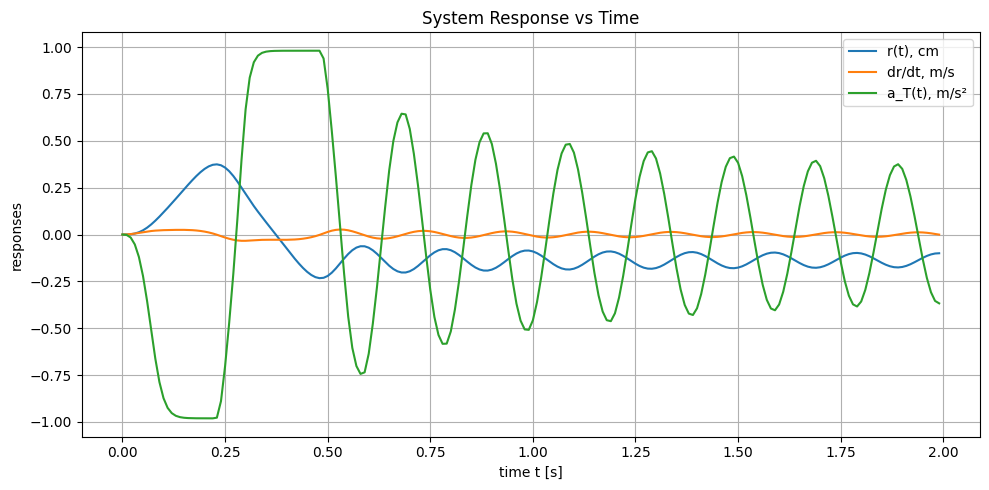

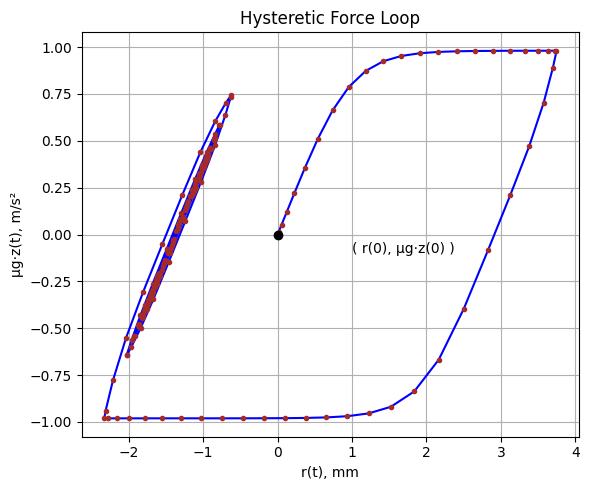

In [18]:
import matplotlib.pyplot as plt
# Extract results
r = x_sol[0, :]
dr = x_sol[1, :]
acc_total = x_drv[1, :] + as_array
fi = y_sol[0, :]

# --- Figure 1: Responses ---
plt.figure(figsize=(10, 5))
plt.plot(time, 100 * r, label='r(t), cm')
plt.plot(time, dr, label='dr/dt, m/s')
plt.plot(time, acc_total, label='a_T(t), m/s²')
plt.xlabel('time t [s]')
plt.ylabel('responses')
plt.legend()
plt.grid(True)
plt.title('System Response vs Time')
plt.tight_layout()
plt.savefig("slidingSim-1.pdf")
plt.show()

# --- Figure 2: Hysteresis (Friction vs Displacement) ---
plt.figure(figsize=(6, 5))
# Blue line
plt.plot(1000 * r, fi, color='blue', label='Friction vs Displacement')
# Brown dots
plt.plot(1000 * r, fi, 'o', color='brown', markersize=3, label='Time Steps')  # r(t) in mm
plt.plot(0, 0, 'ok')  # Initial point
plt.text(1.0, -0.1, '( r(0), μg·z(0) )')
plt.xlabel('r(t), mm')
plt.ylabel('μg·z(t), m/s²')
plt.grid(True)
plt.title('Hysteretic Force Loop')
plt.tight_layout()
plt.savefig("slidingSim-2.pdf")
plt.show()


We Want to check against historic data
First we need to Mount our google drive to see other files

In [6]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


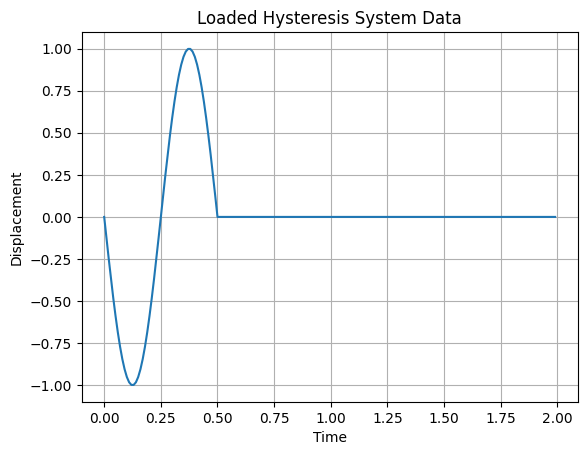

In [23]:
# load given data

# i think this is suppose to be the true results right?
# Seems like both of our code result in different things from this but the same as each other
# what is this file intended for?

# Load the hysteresis system data (matching MATLAB's C = load(...))
file_path = '/content/drive/My Drive/Colab Notebooks/Hysteresis_sys_data.txt'
C = np.loadtxt(file_path, skiprows=1)

# Now access columns like MATLAB: C[:,0], C[:,1], etc.
plt.plot(C[:, 0], C[:, 1])
plt.xlabel("Time")
plt.ylabel("Displacement")
plt.title("Loaded Hysteresis System Data")
plt.grid(True)
plt.show()